In [1]:
from ladybug.epw import EPW
import numpy as np
from ladybug.dt import DateTime, datetime
import pandas as pd
from datetime import timezone, timedelta, tzinfo, timezone

# load test data from a file
epw_file = (r"C:\Users\tgerrish\Documents\GitHub\target_dir\kvrrj\tests\assets\example.epw")
epw = EPW(epw_file)


In [26]:
from kvrrj.solar2 import Solar, AnalysisPeriod, Face3D, Plane, Point3D, Vector3D

sol = Solar.from_epw(epw)

# Solar.from_dict(sol.to_dict()
# Solar.from_json(sol.to_json())
# Solar.from_dataframe(sol.to_dataframe())
# Solar.from_average([sol, sol, sol], weights=[1, 2, 3])

# smx = sol.to_lb_sky_matrix(temperature=epw.dry_bulb_temperature)
# smx

# sol.to_lb_radiation_study(north=34).radiation_values

# create a set of faces pointing in target number of directions at correct tilt angle


<Axes: title={'left': 'example.epw\nJan 01 to Dec 31 between 00:00 and 23:59 every hour'}>

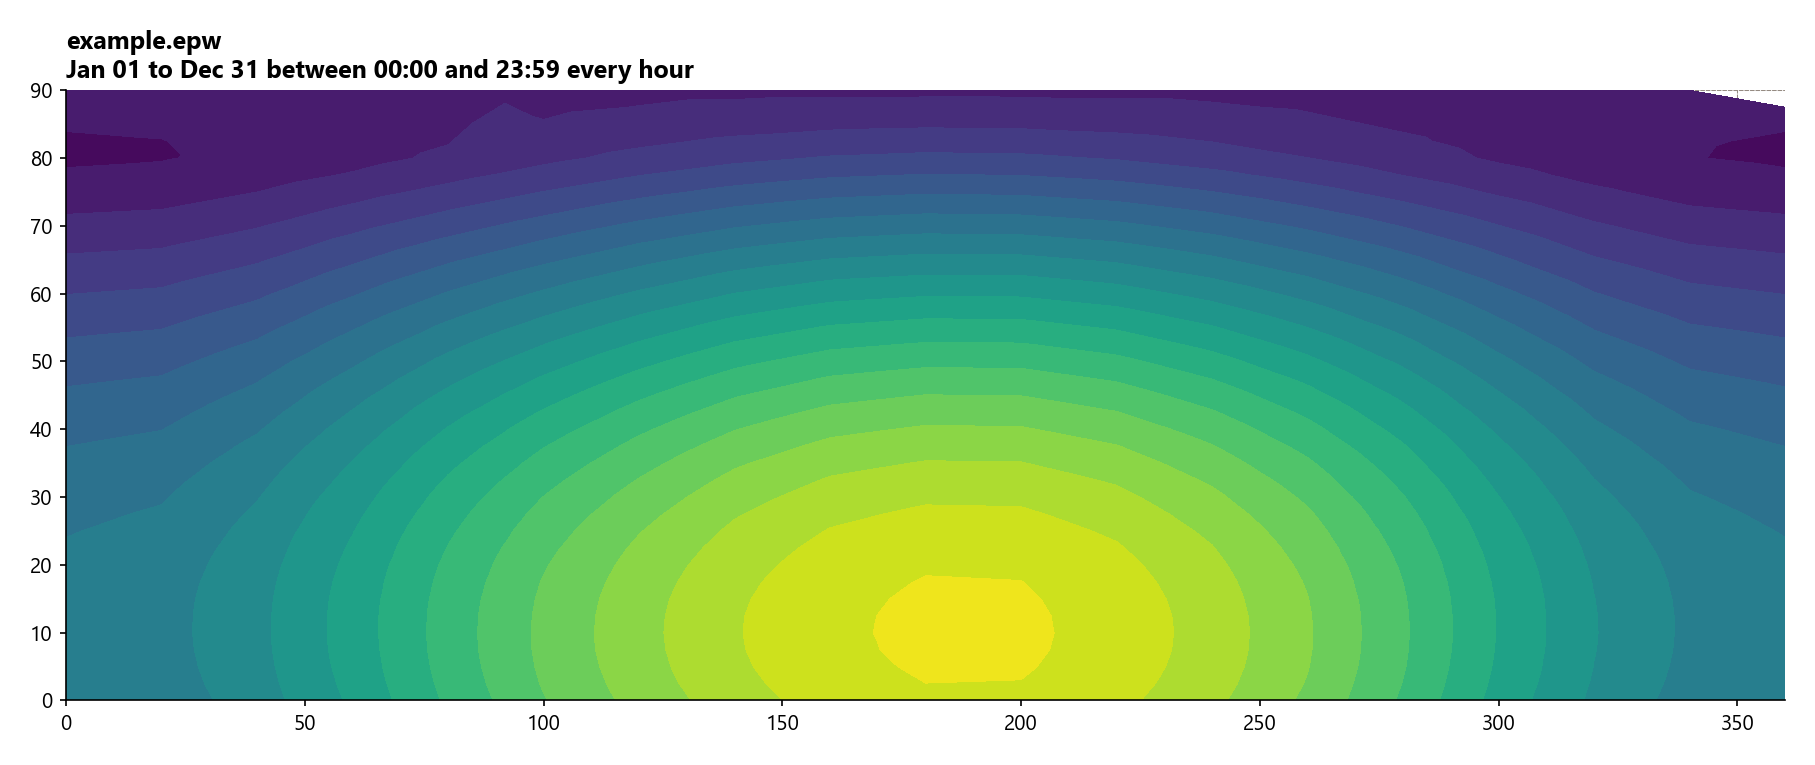

In [186]:
import matplotlib.pyplot as plt

# sol.directional_irradiance(as_dataframe=True).plot()

# sol.radiation_benefit(temperature=epw.dry_bulb_temperature).resample("12h").mean().plot()

# sol.tilt_orientation_irradiance(10, 5)

# _, ax = plt.subplots(subplot_kw={"projection": "polar"})
# sol.plot_radrose(ax=ax, tilt_angle=0.9, analysis_period=AnalysisPeriod(st_hour=13, end_hour=17))

f = Face3D.from_regular_polygon(side_count=4, radius=12, base_plane=Plane(o=Point3D(0, 0, 2)))
sol.plot_tilt_orientation_factor(altitude_count=36, azimuth_count=18, shade_objects=[f])





In [ ]:

df

,azimuth,altitude,value
0,0.0,0.0,229.271826
1,45.0,0.0,299.851489
2,90.0,0.0,472.498853
3,135.0,0.0,657.732032
4,180.0,0.0,746.305636
5,225.0,0.0,690.160545
6,270.0,0.0,507.445404
7,315.0,0.0,316.844862
8,0.0,18.0,313.675259
9,45.0,18.0,409.719257


In [ ]:
# tof calc

from kvrrj.solar2 import RadiationDome


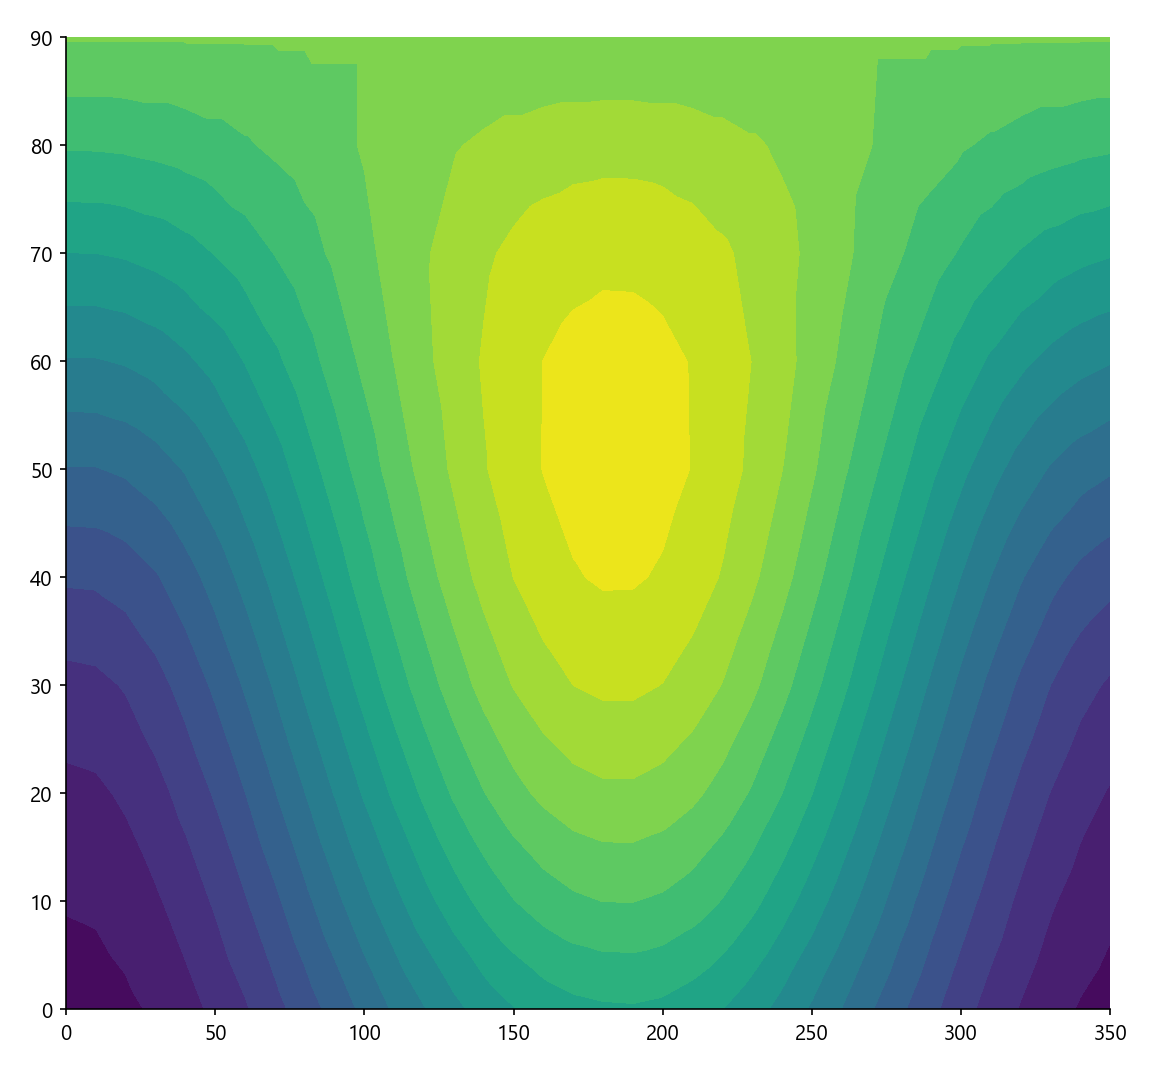

In [ ]:
from kvrrj.geometry.util import vector3d_to_azimuth_altitude

# create a radiation dome
rd = RadiationDome(sol.to_lb_sky_matrix(), azimuth_count=36, altitude_count=9)

# create a list of azimuths
unique_azimuths = np.linspace(0, 360, rd.azimuth_count, endpoint=False)

# get the raw data
azimuths, altitudes = np.array([vector3d_to_azimuth_altitude(i) for i in rd.direction_vectors]).T
values = np.array(rd.total_values)

# find the index of the value where altitude is 90
idx = np.where(altitudes==90)[0]
# get the altitude and value at 90 degrees
altitude_90 = altitudes[idx]
value_90 = values[idx]
# remove the 90 degree values from each list
azimuths = np.delete(azimuths, idx)
values = np.delete(values, idx)
altitudes = np.delete(altitudes, idx)
# create a new list of values at 90 for each azimuth
azimuths = np.concatenate(
    (
        azimuths,
        np.linspace(0, 360, rd.azimuth_count, endpoint=False),
    )
)
altitudes = np.concatenate(
    (
        altitudes,
        np.repeat(90, rd.azimuth_count),
    )
)
values = np.concatenate(
    (
        values,
        np.repeat(value_90, rd.azimuth_count),
    )
)

# plot usiny pcolor
plt.figure(figsize=(8, 8))
plt.tricontourf(azimuths, altitudes, values, levels=20)

# # (altitudes == 0).sum()
# # get the value at 90 altitude
# a


In [ ]:
import scipy
from kvrrj.wind import Wind
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from collections import defaultdict

self = Wind.from_epw(epw).filter_by_speed(min_speed=0.1)
self.plot_windrose(directions=36, other_bins=[0, 5, 10, 15, 20])

In [ ]:
import calendar
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.axes import Axes

from kvrrj.geometry.util import angle_to_vector
from kvrrj.viz.color import contrasting_color

ax: Axes = None
show_values: bool = True
show_arrows: bool = True
other_data: list[float] = [10] * len(self)
kwargs = {}

"""Create a plot showing the annual wind speed and direction bins
using the month_time_average method.

Args:
    ax (plt.Axes, optional):
        The axes to plot on. If None, the current axes will be used.
    show_values (bool, optional):
        Whether to show values in the cells. Defaults to False.
    show_arrows (bool, optional):
        Whether to show the directional arrows on each patch.
    other_data: (pd.Series, optional):
        The other data to align with the wind direction and speed.
        Defaults to None which uses wind speed.
    **kwargs:
        Additional keyword arguments to pass to the pcolor function.
        title (str, optional):
            A title for the plot. Defaults to None.

Returns:
    plt.Axes:
        A matplotlib Axes object.

"""

if ax is None:
    ax = plt.gca()

if other_data is None:
    other_data = self.wind_speeds
    kwargs["vmin"] = kwargs.get("vmin", 0)
    kwargs["unit"] = kwargs.get("unit", "m/s")


ax.set_title(self.source)

df = self.wind_matrix(other_data=other_data)
_wind_directions = df["direction"]
_other_data = df["other"]

cmap = kwargs.pop("cmap", "YlGnBu")
vmin = kwargs.pop("vmin", _other_data.values.min())
vmax = kwargs.pop("vmax", _other_data.values.max())
unit = kwargs.pop("unit", "")
cbar_title = kwargs.pop("cbar_title", None)
norm = kwargs.pop("norm", plt.Normalize(vmin=vmin, vmax=vmax, clip=True))
mapper = kwargs.pop("mapper", ScalarMappable(norm=norm, cmap=cmap))
pc = ax.pcolor(_other_data, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)

if show_arrows:
    _x, _y = np.array(angle_to_vector(_wind_directions.values))
    arrow_scale = 0.8
    ax.quiver(
        np.arange(1, 13, 1) - 0.5,
        np.arange(0, 24, 1) + 0.5,
        (_x * _other_data.values / 2) * arrow_scale,
        (_y * _other_data.values / 2) * arrow_scale,
        pivot="mid",
        fc="white",
        ec="black",
        lw=0.5,
        alpha=0.5,
    )

if show_values:
    for _xx, col in enumerate(_wind_directions.values.T):
        for _yy, wind_dir_value in enumerate(col.T):
            local_value = _other_data.values[_yy, _xx]
            cell_color = mapper.to_rgba(local_value)
            text_color = contrasting_color(cell_color)
            # direction text
            ax.text(
                _xx,
                _yy,
                f"{_wind_directions.values[_yy][_xx]:0.0f}°",
                color=text_color,
                ha="left",
                va="bottom",
                fontsize="xx-small",
            )
            # other_data text
            ax.text(
                _xx + 1,
                _yy + 1,
                f"{_other_data.values[_yy][_xx]:0.1f}{unit}",
                color=text_color,
                ha="right",
                va="top",
                fontsize="xx-small",
            )

# add colorbar
ax.set_xticks([i  - 0.5 for i in range(1, 13, 1)])
ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13, 1)])
ax.set_yticks([i + 0.5 for i in range(24)])
ax.set_yticklabels([f"{i:02d}:00" for i in range(24)])
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

cb = plt.colorbar(pc, label=cbar_title, pad=0.01)
cb.outline.set_visible(False)

In [ ]:

    ax.set_xticks(np.arange(1, 13, 1) - 0.5)
    ax.set_xticklabels([calendar.month_abbr[i] for i in np.arange(1, 13, 1)])
    ax.set_yticks(np.arange(0, 24, 1) + 0.5)
    ax.set_yticklabels([f"{i:02d}:00" for i in np.arange(0, 24, 1)])
    for label in ax.yaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    cb = plt.colorbar(pc, label=cbar_title, pad=0.01)
    cb.outline.set_visible(False)

    return ax